In [18]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import math
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score,confusion_matrix,roc_curve,balanced_accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='7'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

In [5]:
def FilterMassPeaks(df, min_count=None, min_freq=None):
    if min_count is None and min_freq is None:
        raise ValueError("At least one of 'min_count' and 'min_freq' must be provided.")
    elif min_count is not None and min_freq is not None:
        raise ValueError("Only one of 'min_count' and 'min_freq' can be provided.")
        
    # 计算每列中的非零值数量
    non_zero_counts = df.astype(bool).sum(axis=0)
    
    # 根据最小次数或最小频率筛选列
    if min_count is not None:
        filtered_cols = non_zero_counts[non_zero_counts >= min_count].index
    else:
        thresh = df.shape[0] * min_freq
        filtered_cols = non_zero_counts[non_zero_counts >= thresh].index
    
    return df[filtered_cols]

### 1.导入数据和标签

In [6]:
df = LoadMSData(root_path = root_path, data_path = 'data14/jejuni/peaks_all.csv', t = False)
df

,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2171.61,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,Maldi:2241.84,Maldi:2248.85,...,Maldi:8271.93,Maldi:8460.76,Maldi:8544.43,Maldi:8680.23,Maldi:9155.54,Maldi:9551.62,Maldi:9688.51,Maldi:10096.58,Maldi:10276.02,Maldi:10323.79
0,6149.48,0.00,0.00,0.0,0.00,0.0,10760.85,0.00,11385.13,0.0,...,0.00,1423.91,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
1,6441.01,0.00,0.00,0.0,0.00,0.0,7774.66,0.00,11548.13,0.0,...,1243.03,1441.91,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
2,6305.78,0.00,5702.90,0.0,0.00,0.0,6823.47,0.00,6668.57,0.0,...,1309.31,1874.15,0.00,0.0,502.94,0.0,0.00,0.0,0.0,0.00
3,8278.14,0.00,0.00,0.0,0.00,0.0,8360.54,0.00,12058.89,0.0,...,2433.00,1298.04,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
4,4516.29,0.00,3238.39,0.0,0.00,0.0,5561.39,0.00,7341.40,0.0,...,854.21,1064.58,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,6005.60,0.00,0.00,0.0,4318.17,0.0,3739.36,0.00,9570.34,0.0,...,1635.58,2206.56,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
668,12916.29,0.00,0.00,0.0,0.00,0.0,9946.75,3306.91,14698.75,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
669,0.00,0.00,0.00,0.0,0.00,0.0,11879.44,3507.25,11332.95,0.0,...,0.00,4877.86,1519.74,0.0,1131.80,0.0,1328.94,0.0,0.0,0.00
670,4236.87,4744.23,0.00,0.0,0.00,0.0,16336.99,4301.54,0.00,0.0,...,0.00,2847.72,1253.50,0.0,746.29,0.0,0.00,0.0,0.0,2560.66


In [7]:
dfx = FilterMassPeaks(df, min_count=1)
dfx

,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2171.61,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,Maldi:2241.84,Maldi:2248.85,...,Maldi:8271.93,Maldi:8460.76,Maldi:8544.43,Maldi:8680.23,Maldi:9155.54,Maldi:9551.62,Maldi:9688.51,Maldi:10096.58,Maldi:10276.02,Maldi:10323.79
0,6149.48,0.00,0.00,0.0,0.00,0.0,10760.85,0.00,11385.13,0.0,...,0.00,1423.91,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
1,6441.01,0.00,0.00,0.0,0.00,0.0,7774.66,0.00,11548.13,0.0,...,1243.03,1441.91,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
2,6305.78,0.00,5702.90,0.0,0.00,0.0,6823.47,0.00,6668.57,0.0,...,1309.31,1874.15,0.00,0.0,502.94,0.0,0.00,0.0,0.0,0.00
3,8278.14,0.00,0.00,0.0,0.00,0.0,8360.54,0.00,12058.89,0.0,...,2433.00,1298.04,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
4,4516.29,0.00,3238.39,0.0,0.00,0.0,5561.39,0.00,7341.40,0.0,...,854.21,1064.58,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,6005.60,0.00,0.00,0.0,4318.17,0.0,3739.36,0.00,9570.34,0.0,...,1635.58,2206.56,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
668,12916.29,0.00,0.00,0.0,0.00,0.0,9946.75,3306.91,14698.75,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00
669,0.00,0.00,0.00,0.0,0.00,0.0,11879.44,3507.25,11332.95,0.0,...,0.00,4877.86,1519.74,0.0,1131.80,0.0,1328.94,0.0,0.0,0.00
670,4236.87,4744.23,0.00,0.0,0.00,0.0,16336.99,4301.54,0.00,0.0,...,0.00,2847.72,1253.50,0.0,746.29,0.0,0.00,0.0,0.0,2560.66


In [8]:
#Labels Loading 读入原始标签
Labels = pd.read_csv(r'/raid/lzyt_dir/Data/data14/jejuni/labels_all.csv',header=None)
Y = np.array(Labels)
#Multi-hot Labels Loading 生成训练标签
#S 0;Cip 1;Strep 2;Tet 3;Amp 4;Kana 5;
labelValue = {'S': 0,'Cip': 1, 'Strep': 2,'Tet': 3,'Amp': 4,'Kana': 5,}
labels = ['Cip','Tet','Amp','Kana','Strep']
train_Y = np.zeros((672,6))

i = 0
for Label in Y:
    Label = Label[0]
    if(Label == 'S') :
        train_Y[i][0] = 1
    else :
        for label in labels:
            if(label in Label) :
                train_Y[i][labelValue[label]] = 1
    i = i + 1

Multi_y = train_Y.astype(int)

In [9]:
from sklearn.preprocessing import OneHotEncoder
one_hot_labels = []
for label, index in labelValue.items():
    Label_Y = Multi_y[:,index]
    # 创建一个OneHotEncoder对象
    encoder = OneHotEncoder(sparse=False)
    # 将labels转换为二维独热编码标签数组
    one_hot_label = encoder.fit_transform(Label_Y.reshape(-1, 1))
    one_hot_labels.append(one_hot_label)

### 2.生成特征图

In [10]:
mp = load('/mnt/lzyt/SmallSamples/data12/aggmap/aggmap_jejuni_mincount_1.mp')
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 672/672 [00:04<00:00, 161.09it/s]


### 3.模型训练测试（demo）

In [ ]:
#划分验证集并调整classweight
clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[2, 6, 24],batch_size=64,epochs=20,metric = 'AUC',gpuid=5,verbose=0,printOrNot = True)
clf.fit(X_train, Y_train)
PlotCurve(clf.history)

y_pred = clf.predict(X_test)
print(Y_test[:,1].astype(int))
print(y_pred)
print('auc = ',roc_auc_score(Y_test[:,1],y_pred))

Epoch 1/30
11/11 - 2s - loss: 1.0128 - accuracy: 0.5228 - val_loss: 0.6942 - val_accuracy: 0.5957
Epoch 2/30
11/11 - 0s - loss: 0.7550 - accuracy: 0.5836 - val_loss: 0.6745 - val_accuracy: 0.5390
Epoch 3/30
11/11 - 0s - loss: 0.6365 - accuracy: 0.6900 - val_loss: 0.7290 - val_accuracy: 0.5745
Epoch 4/30
11/11 - 0s - loss: 0.5082 - accuracy: 0.7477 - val_loss: 0.7495 - val_accuracy: 0.5745
Epoch 5/30
11/11 - 0s - loss: 0.4560 - accuracy: 0.7903 - val_loss: 0.7391 - val_accuracy: 0.5957
Epoch 6/30
11/11 - 0s - loss: 0.3913 - accuracy: 0.8237 - val_loss: 0.7194 - val_accuracy: 0.5745
Epoch 7/30
11/11 - 0s - loss: 0.3187 - accuracy: 0.8693 - val_loss: 0.7452 - val_accuracy: 0.5816
Epoch 8/30
11/11 - 0s - loss: 0.2627 - accuracy: 0.9149 - val_loss: 0.7304 - val_accuracy: 0.5887
Epoch 9/30
11/11 - 0s - loss: 0.2410 - accuracy: 0.8997 - val_loss: 0.7277 - val_accuracy: 0.6525
Epoch 10/30
11/11 - 0s - loss: 0.2243 - accuracy: 0.9362 - val_loss: 0.7565 - val_accuracy: 0.6028
Epoch 11/30
11/11 -

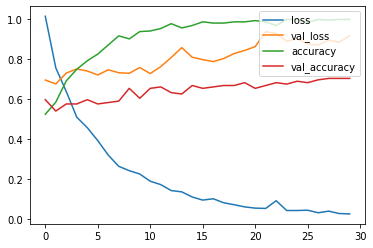

Confusion Matrix: 
[[92 29]
 [32 49]]
Validation Accuracy: 69.80%
Validation Sensitivity: 60.49%
Validation Specificity: 76.03%
Validation Balanced accuracy: 68.26%
Validation AUC: 0.7640


In [82]:
#划分验证集并调整classweight
num = 4
Y = Multi_y[:,num]
y = one_hot_labels[num]
Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
test_y = test_Y[:,1]
train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)

#model 
clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 12],batch_size=32,
                                   dropout=0.1,epochs=30,verbose=2,gpuid=7)
clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
        class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
y_pro = clf.predict_proba(test_X)
y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
y_pred = np.argmax(y_pro, axis=1)

#plot train curve
PlotCurve(clf.history)

#MADLINet Test Metrics
Overall_accuracy = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
AUC = roc_auc_score(test_y, y_raw)

print('Confusion Matrix: ')
print(conf_matrix)
print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
print('Validation AUC: {:5.4f}'.format(AUC))

### 保存一套参数

Epoch 1/30
11/11 - 2s - loss: 1.0037 - accuracy: 0.5745 - val_loss: 0.6176 - val_accuracy: 0.6879
Epoch 2/30
11/11 - 0s - loss: 0.6921 - accuracy: 0.6869 - val_loss: 0.6296 - val_accuracy: 0.6454
Epoch 3/30
11/11 - 0s - loss: 0.6163 - accuracy: 0.7447 - val_loss: 0.5916 - val_accuracy: 0.7021
Epoch 4/30
11/11 - 0s - loss: 0.5429 - accuracy: 0.7538 - val_loss: 0.6519 - val_accuracy: 0.6738
Epoch 5/30
11/11 - 0s - loss: 0.4984 - accuracy: 0.7629 - val_loss: 0.5725 - val_accuracy: 0.7447
Epoch 6/30
11/11 - 0s - loss: 0.4335 - accuracy: 0.7842 - val_loss: 0.5868 - val_accuracy: 0.7234
Epoch 7/30
11/11 - 0s - loss: 0.3685 - accuracy: 0.8359 - val_loss: 0.5873 - val_accuracy: 0.7447
Epoch 8/30
11/11 - 0s - loss: 0.3360 - accuracy: 0.8784 - val_loss: 0.5966 - val_accuracy: 0.7589
Epoch 9/30
11/11 - 0s - loss: 0.2698 - accuracy: 0.8997 - val_loss: 0.5590 - val_accuracy: 0.7801
Epoch 10/30
11/11 - 0s - loss: 0.2355 - accuracy: 0.9058 - val_loss: 0.5920 - val_accuracy: 0.7376
Epoch 11/30
11/11 -

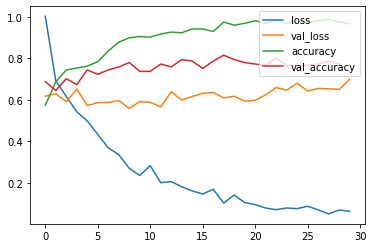

Confusion Matrix: 
[[109  30]
 [ 24  39]]
Validation Accuracy: 73.27%
Validation Sensitivity: 61.90%
Validation Specificity: 78.42%
Validation Balanced accuracy: 70.16%
Validation AUC: 0.7642
Epoch 1/30
11/11 - 2s - loss: 1.2052 - accuracy: 0.4985 - val_loss: 0.8348 - val_accuracy: 0.4539
Epoch 2/30
11/11 - 0s - loss: 0.7743 - accuracy: 0.6140 - val_loss: 0.7424 - val_accuracy: 0.4965
Epoch 3/30
11/11 - 0s - loss: 0.7271 - accuracy: 0.6778 - val_loss: 0.5745 - val_accuracy: 0.7163
Epoch 4/30
11/11 - 0s - loss: 0.5726 - accuracy: 0.7416 - val_loss: 0.5411 - val_accuracy: 0.7021
Epoch 5/30
11/11 - 0s - loss: 0.5177 - accuracy: 0.7295 - val_loss: 0.5505 - val_accuracy: 0.6950
Epoch 6/30
11/11 - 0s - loss: 0.4783 - accuracy: 0.7690 - val_loss: 0.5306 - val_accuracy: 0.7234
Epoch 7/30
11/11 - 0s - loss: 0.3477 - accuracy: 0.8450 - val_loss: 0.5482 - val_accuracy: 0.7447
Epoch 8/30
11/11 - 0s - loss: 0.4010 - accuracy: 0.8237 - val_loss: 0.5250 - val_accuracy: 0.7234
Epoch 9/30
11/11 - 0s - 

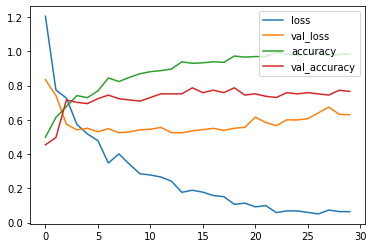

Confusion Matrix: 
[[68 23]
 [36 75]]
Validation Accuracy: 70.79%
Validation Sensitivity: 67.57%
Validation Specificity: 74.73%
Validation Balanced accuracy: 71.15%
Validation AUC: 0.7788
Epoch 1/30
11/11 - 2s - loss: 0.9413 - accuracy: 0.6261 - val_loss: 0.3687 - val_accuracy: 0.9504
Epoch 2/30
11/11 - 0s - loss: 0.6104 - accuracy: 0.7386 - val_loss: 0.3858 - val_accuracy: 0.9007
Epoch 3/30
11/11 - 0s - loss: 0.4346 - accuracy: 0.8055 - val_loss: 0.3519 - val_accuracy: 0.8723
Epoch 4/30
11/11 - 0s - loss: 0.3250 - accuracy: 0.7872 - val_loss: 0.2901 - val_accuracy: 0.8723
Epoch 5/30
11/11 - 0s - loss: 0.1569 - accuracy: 0.9027 - val_loss: 0.2012 - val_accuracy: 0.9149
Epoch 6/30
11/11 - 0s - loss: 0.3376 - accuracy: 0.9149 - val_loss: 0.2184 - val_accuracy: 0.9220
Epoch 7/30
11/11 - 0s - loss: 0.1503 - accuracy: 0.9453 - val_loss: 0.1741 - val_accuracy: 0.9574
Epoch 8/30
11/11 - 0s - loss: 0.1624 - accuracy: 0.9605 - val_loss: 0.1698 - val_accuracy: 0.9433
Epoch 9/30
11/11 - 0s - loss

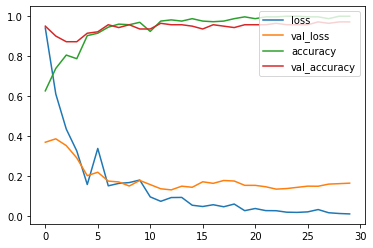

Confusion Matrix: 
[[191   1]
 [  4   6]]
Validation Accuracy: 97.52%
Validation Sensitivity: 60.00%
Validation Specificity: 99.48%
Validation Balanced accuracy: 79.74%
Validation AUC: 0.8854
Epoch 1/30
11/11 - 2s - loss: 1.1444 - accuracy: 0.5471 - val_loss: 0.6789 - val_accuracy: 0.5957
Epoch 2/30
11/11 - 0s - loss: 0.9288 - accuracy: 0.6018 - val_loss: 0.7012 - val_accuracy: 0.5248
Epoch 3/30
11/11 - 0s - loss: 0.7023 - accuracy: 0.6626 - val_loss: 0.6344 - val_accuracy: 0.6312
Epoch 4/30
11/11 - 0s - loss: 0.6209 - accuracy: 0.6626 - val_loss: 0.6633 - val_accuracy: 0.6170
Epoch 5/30
11/11 - 0s - loss: 0.5491 - accuracy: 0.7052 - val_loss: 0.6646 - val_accuracy: 0.6170
Epoch 6/30
11/11 - 0s - loss: 0.5008 - accuracy: 0.7568 - val_loss: 0.7025 - val_accuracy: 0.5887
Epoch 7/30
11/11 - 0s - loss: 0.4660 - accuracy: 0.7872 - val_loss: 0.6365 - val_accuracy: 0.6525
Epoch 8/30
11/11 - 0s - loss: 0.3464 - accuracy: 0.8602 - val_loss: 0.6447 - val_accuracy: 0.6454
Epoch 9/30
11/11 - 0s - 

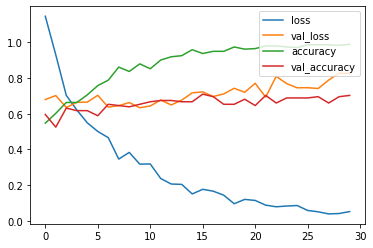

Confusion Matrix: 
[[90 31]
 [35 46]]
Validation Accuracy: 67.33%
Validation Sensitivity: 56.79%
Validation Specificity: 74.38%
Validation Balanced accuracy: 65.59%
Validation AUC: 0.7532
Epoch 1/30
11/11 - 2s - loss: 1.1140 - accuracy: 0.5289 - val_loss: 0.6998 - val_accuracy: 0.5957
Epoch 2/30
11/11 - 0s - loss: 0.9024 - accuracy: 0.5593 - val_loss: 0.7106 - val_accuracy: 0.5319
Epoch 3/30
11/11 - 0s - loss: 0.7186 - accuracy: 0.6687 - val_loss: 0.6647 - val_accuracy: 0.5603
Epoch 4/30
11/11 - 0s - loss: 0.6787 - accuracy: 0.6657 - val_loss: 0.6857 - val_accuracy: 0.5887
Epoch 5/30
11/11 - 0s - loss: 0.5371 - accuracy: 0.7508 - val_loss: 0.7052 - val_accuracy: 0.6170
Epoch 6/30
11/11 - 0s - loss: 0.4830 - accuracy: 0.7690 - val_loss: 0.6674 - val_accuracy: 0.6170
Epoch 7/30
11/11 - 0s - loss: 0.5324 - accuracy: 0.7416 - val_loss: 0.6551 - val_accuracy: 0.6241
Epoch 8/30
11/11 - 0s - loss: 0.3844 - accuracy: 0.8116 - val_loss: 0.6684 - val_accuracy: 0.6454
Epoch 9/30
11/11 - 0s - loss

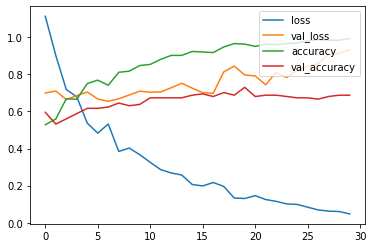

Confusion Matrix: 
[[99 22]
 [45 36]]
Validation Accuracy: 66.83%
Validation Sensitivity: 44.44%
Validation Specificity: 81.82%
Validation Balanced accuracy: 63.13%
Validation AUC: 0.7491
Epoch 1/30
11/11 - 2s - loss: 1.0936 - accuracy: 0.5562 - val_loss: 0.4348 - val_accuracy: 0.9220
Epoch 2/30
11/11 - 0s - loss: 0.9310 - accuracy: 0.6839 - val_loss: 0.6550 - val_accuracy: 0.6454
Epoch 3/30
11/11 - 0s - loss: 0.5909 - accuracy: 0.7204 - val_loss: 0.6071 - val_accuracy: 0.6879
Epoch 4/30
11/11 - 0s - loss: 0.6509 - accuracy: 0.6353 - val_loss: 0.5766 - val_accuracy: 0.7234
Epoch 5/30
11/11 - 0s - loss: 0.3970 - accuracy: 0.7994 - val_loss: 0.4247 - val_accuracy: 0.8440
Epoch 6/30
11/11 - 0s - loss: 0.3708 - accuracy: 0.8571 - val_loss: 0.3349 - val_accuracy: 0.9007
Epoch 7/30
11/11 - 0s - loss: 0.3402 - accuracy: 0.8723 - val_loss: 0.3796 - val_accuracy: 0.8723
Epoch 8/30
11/11 - 0s - loss: 0.2361 - accuracy: 0.8875 - val_loss: 0.3575 - val_accuracy: 0.8865
Epoch 9/30
11/11 - 0s - loss

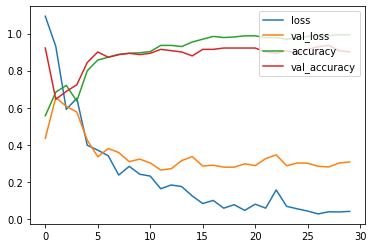

Confusion Matrix: 
[[180   6]
 [  4  12]]
Validation Accuracy: 95.05%
Validation Sensitivity: 75.00%
Validation Specificity: 96.77%
Validation Balanced accuracy: 85.89%
Validation AUC: 0.9022


In [31]:
auc_scores = []
for i in range(len(one_hot_labels)):
    Y = Multi_y[:,i]
    y = one_hot_labels[i]
    Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
    #划分验证集并调整classweight
    test_y = test_Y[:,1]
    train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)

    #model 
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 24],batch_size=32,
                                       dropout=0.2,epochs=30,verbose=2,gpuid=7)
    clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
            class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
    y_pro = clf.predict_proba(test_X)
    y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
    y_pred = np.argmax(y_pro, axis=1)

    #plot train curve
    PlotCurve(clf.history)

    #MADLINet Test Metrics
    Overall_accuracy = accuracy_score(test_y, y_pred)
    conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
    AUC = roc_auc_score(test_y, y_raw)
    auc_scores.append(AUC)

    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))

In [32]:
valueLabel = {value: key for key, value in labelValue.items()}
for i in range(len(auc_scores)):
    print(f'{valueLabel.get(i)} auc is {auc_scores[i]}')

S auc is 0.7641886490807355
Cip auc is 0.7788337788337788
Strep auc is 0.8854166666666667
Tet auc is 0.7531884501581471
Amp auc is 0.7491072339557188
Kana auc is 0.9022177419354838


### 标签结果展示

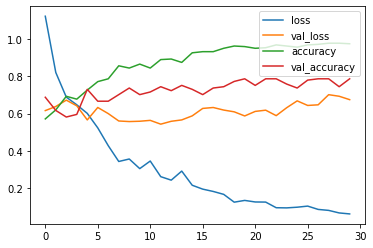

Confusion Matrix: 
[[125  14]
 [ 28  35]]
Validation Accuracy: 79.21%
Validation Sensitivity: 55.56%
Validation Specificity: 89.93%
Validation Balanced accuracy: 72.74%
Validation AUC: 0.8244


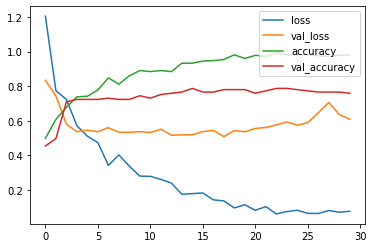

Confusion Matrix: 
[[64 27]
 [32 79]]
Validation Accuracy: 70.79%
Validation Sensitivity: 71.17%
Validation Specificity: 70.33%
Validation Balanced accuracy: 70.75%
Validation AUC: 0.7782


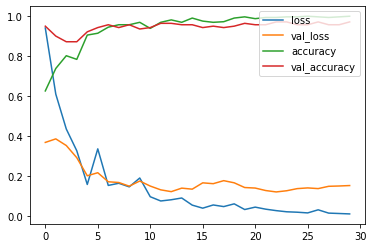

Confusion Matrix: 
[[191   1]
 [  5   5]]
Validation Accuracy: 97.03%
Validation Sensitivity: 50.00%
Validation Specificity: 99.48%
Validation Balanced accuracy: 74.74%
Validation AUC: 0.8677
Epoch 1/25
11/11 - 2s - loss: 1.0459 - accuracy: 0.5623 - val_loss: 0.6820 - val_accuracy: 0.5957
Epoch 2/25
11/11 - 0s - loss: 0.8904 - accuracy: 0.5866 - val_loss: 0.7622 - val_accuracy: 0.4681
Epoch 3/25
11/11 - 0s - loss: 0.6784 - accuracy: 0.6839 - val_loss: 0.7106 - val_accuracy: 0.6028
Epoch 4/25
11/11 - 0s - loss: 0.6632 - accuracy: 0.6565 - val_loss: 0.6649 - val_accuracy: 0.6738
Epoch 5/25
11/11 - 0s - loss: 0.5652 - accuracy: 0.7112 - val_loss: 0.6435 - val_accuracy: 0.6950
Epoch 6/25
11/11 - 0s - loss: 0.5054 - accuracy: 0.7690 - val_loss: 0.6671 - val_accuracy: 0.6667
Epoch 7/25
11/11 - 0s - loss: 0.5083 - accuracy: 0.7416 - val_loss: 0.6095 - val_accuracy: 0.7092
Epoch 8/25
11/11 - 0s - loss: 0.4180 - accuracy: 0.8298 - val_loss: 0.6139 - val_accuracy: 0.7021
Epoch 9/25
11/11 - 0s - 

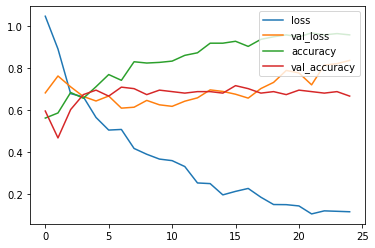

Confusion Matrix: 
[[93 28]
 [36 45]]
Validation Accuracy: 68.32%
Validation Sensitivity: 55.56%
Validation Specificity: 76.86%
Validation Balanced accuracy: 66.21%
Validation AUC: 0.7618
Epoch 1/30
11/11 - 2s - loss: 1.0122 - accuracy: 0.5198 - val_loss: 0.6930 - val_accuracy: 0.5957
Epoch 2/30
11/11 - 0s - loss: 0.7545 - accuracy: 0.5866 - val_loss: 0.6753 - val_accuracy: 0.5319
Epoch 3/30
11/11 - 0s - loss: 0.6378 - accuracy: 0.6930 - val_loss: 0.7283 - val_accuracy: 0.5745
Epoch 4/30
11/11 - 0s - loss: 0.5087 - accuracy: 0.7538 - val_loss: 0.7553 - val_accuracy: 0.5603
Epoch 5/30
11/11 - 0s - loss: 0.4576 - accuracy: 0.7933 - val_loss: 0.7419 - val_accuracy: 0.5957
Epoch 6/30
11/11 - 0s - loss: 0.3963 - accuracy: 0.8207 - val_loss: 0.7248 - val_accuracy: 0.5674
Epoch 7/30
11/11 - 0s - loss: 0.3253 - accuracy: 0.8632 - val_loss: 0.7512 - val_accuracy: 0.5957
Epoch 8/30
11/11 - 0s - loss: 0.2621 - accuracy: 0.8997 - val_loss: 0.7384 - val_accuracy: 0.6099
Epoch 9/30
11/11 - 0s - loss

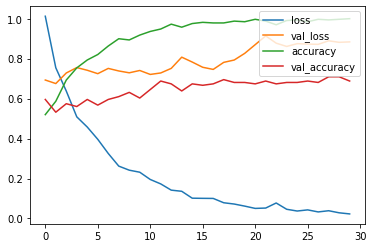

Confusion Matrix: 
[[95 26]
 [32 49]]
Validation Accuracy: 71.29%
Validation Sensitivity: 60.49%
Validation Specificity: 78.51%
Validation Balanced accuracy: 69.50%
Validation AUC: 0.7623


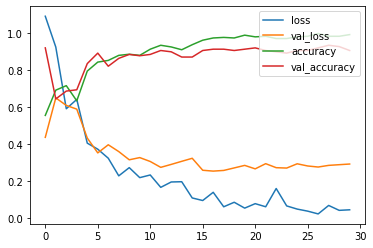

Confusion Matrix: 
[[181   5]
 [  5  11]]
Validation Accuracy: 95.05%
Validation Sensitivity: 68.75%
Validation Specificity: 97.31%
Validation Balanced accuracy: 83.03%
Validation AUC: 0.9059


In [83]:
auc_scores = []
for i in range(len(one_hot_labels)):
    Y = Multi_y[:,i]
    y = one_hot_labels[i]
    Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
    #划分验证集并调整classweight
    test_y = test_Y[:,1]
    train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)
#labelValue = {'S': 0,'Cip': 1, 'Strep': 2,'Tet': 3,'Amp': 4,'Kana': 5,}
    #model 
    if i == 0:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 12, 12],batch_size=32,
                                           dropout=0.2,epochs=30,verbose=0,gpuid=7)
    elif i == 3:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 12],batch_size=32,
                                           dropout=0.2,epochs=25,verbose=2,gpuid=7)
    elif i ==4:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 12],batch_size=32,
                                           dropout=0.1,epochs=30,verbose=2,gpuid=7)
    else :
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 24],batch_size=32,
                                           dropout=0.2,epochs=30,verbose=0,gpuid=7)
    clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
            class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
    y_pro = clf.predict_proba(test_X)
    y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
    y_pred = np.argmax(y_pro, axis=1)

    #plot train curve
    PlotCurve(clf.history)

    #MADLINet Test Metrics
    Overall_accuracy = accuracy_score(test_y, y_pred)
    conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
    AUC = roc_auc_score(test_y, y_raw)
    auc_scores.append(AUC)

    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))

In [84]:
valueLabel = {value: key for key, value in labelValue.items()}
for i in range(len(auc_scores)):
    print(f'{valueLabel.get(i)} auc is {auc_scores[i]}')
np.mean(auc_scores)

S auc is 0.8243690761676373
Cip auc is 0.7782397782397783
Strep auc is 0.8677083333333333
Tet auc is 0.7617590041832466
Amp auc is 0.76226915620855
Kana auc is 0.9059139784946236


0.8167098877711948